## Port Elizabeth Crime Forecasting
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Uitenhage</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Despatch</li>
<li>Kwazakele</li>
</ul>

### Importing libraries

In [2]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px

In [3]:
#sns.set_style("darkgrid")

### Data preprocessing

In [4]:
df = pd.read_csv('crimedata.csv', thousands=',') #Thousands are seperated by commas in the CSV.

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
Crime                  0
Crimes                 0
Police Station         0
Province               0
Crime Category         0
Latitude               0
Longitude              0
Latitude, Longitude    0
Year                   0
dtype: int64


Index(['Crime', 'Crimes', 'Police Station', 'Province', 'Crime Category',
       'Latitude', 'Longitude', 'Latitude, Longitude', 'Year'],
      dtype='object')


### What are the datatypes used?

In [5]:
df.dtypes

Crime                   object
Crimes                   int64
Police Station          object
Province                object
Crime Category          object
Latitude               float64
Longitude              float64
Latitude, Longitude     object
Year                     int64
dtype: object

#### What does the csv file look like?

In [6]:
df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year
0,Murder,5,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
1,Attempted murder,3,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
2,Assault with the intent to inflict grievous bo...,67,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
3,Common assault,31,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
4,Common robbery,2,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
...,...,...,...,...,...,...,...,...,...
345295,Shoplifting,210,Wynberg,Western Cape,Other Serious Crimes,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345296,Illegal possession of firearms and ammunition,8,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345297,Drug-related crime,581,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345298,Driving under the influence of alcohol or drugs,252,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019


#### Limit provinces to only Eastern Cape. After some careful analysis, I found out that there is some incorrect data that has been input. The Police Station 'Doringkloof' does not exist within the Eastern Cape. Doringkloof is a suburb in Gauteng. Therefore, we remove this.

In [7]:
df = df[df['Province'] == 'Eastern Cape']
df = df[df['Police Station'] != 'Doringkloof']

### Limit to police stations in Port Elizabeth only

In [8]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Uitenhage", "Bethelsdorp", "Motherwell"
            , "Despatch", "Kwazakele", "Kamesh", "Kwanobuhle", "Ikamvelihle"]
df = df[df['Police Station'].isin(stations)]
df.drop(['Latitude, Longitude', 'Province'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('PEcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within PE only

### Let's load the SHP file of South Africa

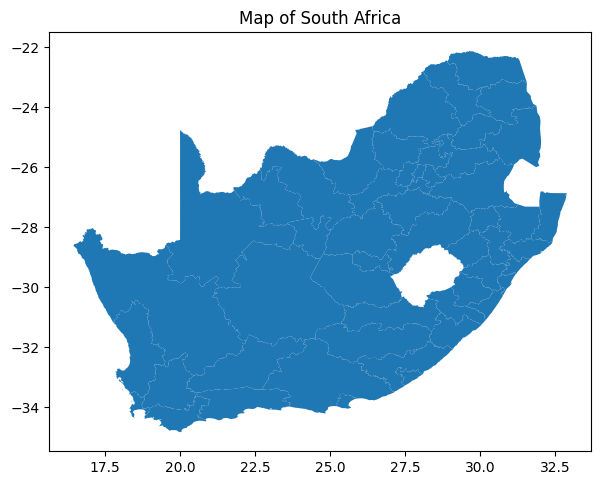

In [9]:
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_2.shp")
fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax = ax)
plt.title('Map of South Africa')
plt.show()

### Let's plot the police stations within Port Elizabeth only.

##### But first, group by police station and sum the crimes.

In [10]:
sum_crimes = df.groupby(['Police Station'])['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = df['Latitude'].unique()
sum_crimes['Longitude'] = df['Longitude'].unique()
sum_crimes['size'] = sum_crimes['Crimes'] / 60
    
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(sum_crimes, crs = {'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(sum_crimes['Longitude'], sum_crimes['Latitude'])])

c:\Users\anili\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


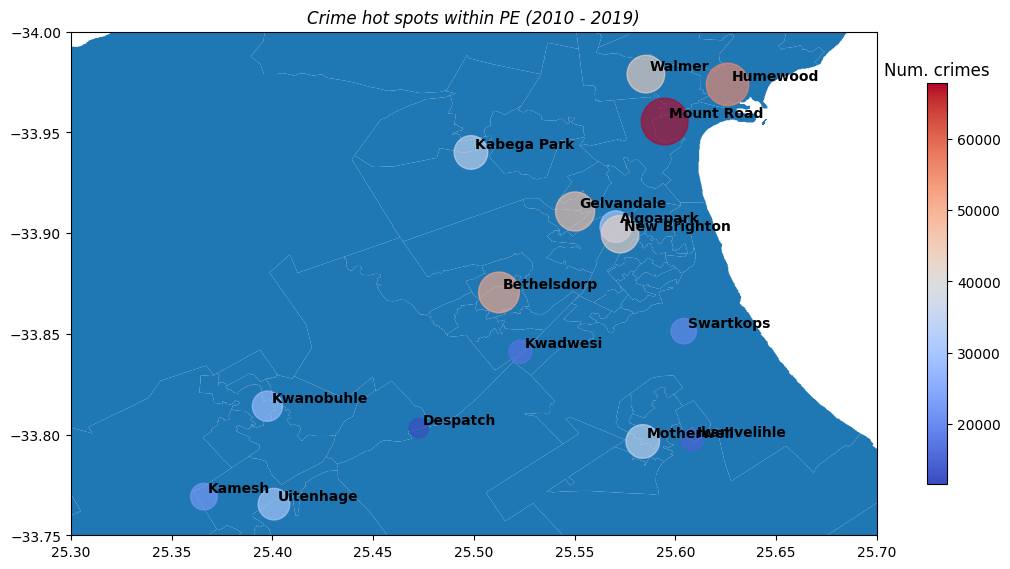

In [11]:
fig, ax = plt.subplots(figsize=(13,13))
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_4.shp")
map.plot(ax=ax, aspect=1) #Plot the map of South Africa
geo_df.plot(aspect=1, column='Crimes', ax=ax, markersize='size', cmap='coolwarm', legend=True, alpha=0.65, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same SA map.
ax.set_ylim([-33.75, -34])
ax.set_xlim([25.3, 25.7])
plt.title('Crime hot spots within PE (2010 - 2019)', style='italic')
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", weight='bold')
ax.get_figure().get_axes()[1].set_title("Num. crimes")
plt.show()

### An interactive map of crime hotspots in PE

In [12]:
fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=3, height=600, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<span style="color: #FFFF00">Kwazakele is a police station in Port Elizabeth, but displays outside of PE. What should I do?</span>

In [ ]:
geo_df

,Police Station,Crimes,Latitude,Longitude,size,geometry
0,Algoapark,31144,-33.903171,25.570496,519.066667,POINT (25.57050 -33.90317)
1,Bethelsdorp,51610,-33.870520,25.512471,860.166667,POINT (25.51247 -33.87052)
2,Despatch,11619,-33.803171,25.472662,193.650000,POINT (25.47266 -33.80317)
3,Gelvandale,47519,-33.910708,25.550250,791.983333,POINT (25.55025 -33.91071)
4,Humewood,56020,-33.973749,25.625900,933.666667,POINT (25.62590 -33.97375)
5,Ikamvelihle,14836,-33.797272,25.608320,247.266667,POINT (25.60832 -33.79727)
6,Kabega Park,35218,-33.939980,25.498567,586.966667,POINT (25.49857 -33.93998)
7,Kamesh,22196,-33.769185,25.366036,369.933333,POINT (25.36604 -33.76919)
8,Kwadwesi,16837,-33.841086,25.523082,280.616667,POINT (25.52308 -33.84109)
9,Kwanobuhle,28401,-33.814058,25.397537,473.350000,POINT (25.39754 -33.81406)


### Let's do some EDA

In [18]:
df_grouped = df.groupby(['Police Station'])['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'])['Crimes'].sum()
df_grouped_y = df.groupby(['Year'])['Crimes'].sum()

Year
2010    64865
2011    63833
2012    62806
2013    63096
2014    63781
2015    61464
2016    58848
2017    58923
2018    55562
2019    54077
Name: Crimes, dtype: int64

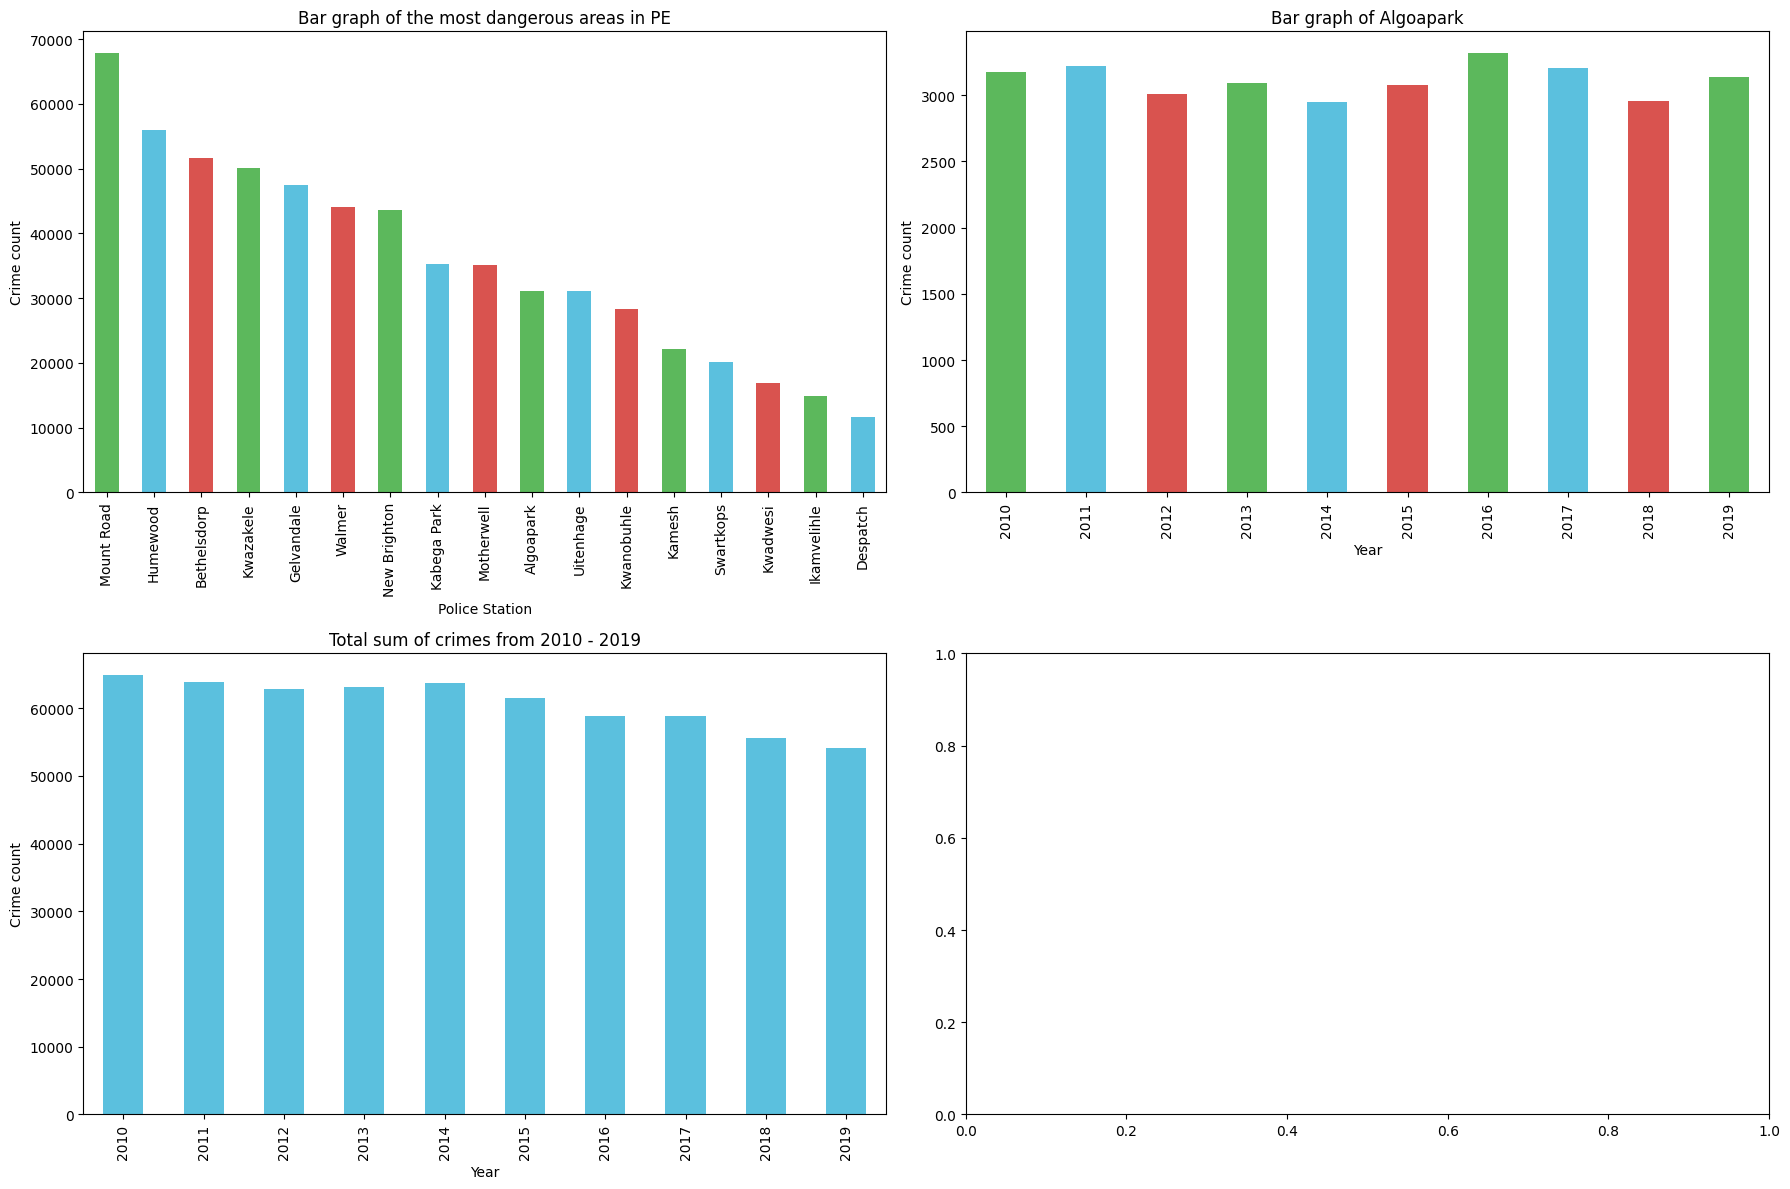

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])
df_grouped_y.plot.bar(color=['#5bc0de'], ax=axs[1,0])

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('Police Station')
axs[0,0].set_ylabel('Crime count')

axs[0,1].set_title('Bar graph of Algoapark')
axs[0,1].set_xlabel('Year')
axs[0,1].set_ylabel('Crime count')

axs[1,0].set_title('Total sum of crimes from 2010 - 2019')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Crime count')

plt.tight_layout()

In [18]:
df_grouped = df_grouped.reset_index()
df_grouped

,Police Station,Crimes
0,Algoapark,31144
1,Bethelsdorp,51610
2,Despatch,11619
3,Gelvandale,47519
4,Humewood,56020
5,Ikamvelihle,14836
6,Kabega Park,35218
7,Kamesh,22196
8,Kwadwesi,16837
9,Kwanobuhle,28401


In [19]:
fig = px.pie(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
fig.update_layout(margin=dict(t=70, b=20, l=0, r=0))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [20]:
# fig = px.treemap(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
# fig.show()

df.groupby(['Crime Category'])['Crimes'].sum().sort_values(ascending=False)

Crime Category
Contact Crimes                                 167886
Property-Related Crimes                        151086
Other Serious Crimes                           126493
Crime detected as a result of Police Action     83113
Contact-Related Crimes                          43185
Aggravated Robbery                              18369
Sexual Offences                                 17123
Name: Crimes, dtype: int64

#### There are 30 unique classes of crimes with 7 unique crime categories

In [21]:
df[(df['Police Station'] == 'Algoapark') & (df['Year'] == 2019)]

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
4590,Murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4591,Attempted murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4592,Assault with the intent to inflict grievous bo...,137,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4593,Common assault,223,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4594,Common robbery,81,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4595,Robbery with aggravating circumstances,262,Algoapark,Contact Crimes,-33.903171,25.570496,2019
4596,Rape,52,Algoapark,Sexual Offences,-33.903171,25.570496,2019
4597,Sexual Assault,12,Algoapark,Sexual Offences,-33.903171,25.570496,2019
4598,Attempted Sexual Offences,0,Algoapark,Sexual Offences,-33.903171,25.570496,2019
4599,Contact Sexual Offences,7,Algoapark,Sexual Offences,-33.903171,25.570496,2019


### Now, for the actual Machine Learning

#### Import

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

#### Data aquisition and categorical encoding

In [34]:
X = df.drop(['Crime Category', 'Crime', 'Latitude', 'Longitude'], axis=1)
y = df.iloc[:, 0]

# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
# X = ct.fit_transform(X)
X

,Crimes,Police Station,Year
0,20,Algoapark,2010
1,14,Algoapark,2010
2,158,Algoapark,2010
3,369,Algoapark,2010
4,54,Algoapark,2010
...,...,...,...
5095,127,Walmer,2019
5096,26,Walmer,2019
5097,305,Walmer,2019
5098,154,Walmer,2019


#### Sampling/split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [35]:
clfRandom = RandomForestClassifier()
clfAda = AdaBoostClassifier()
clfCat = CatBoostClassifier(verbose=0, n_estimators=100, cat_features=['Police Station'])

clfCat.fit(X_train, y_train)
#clfRandom.fit(X_train, y_train)
#clfAda.fit(X_train, y_train)

#### Cross-validation

In [36]:
cv = KFold(n_splits=5)

cv_score_Cat = cross_val_score(clfCat, X_train, y_train, cv=cv, scoring='f1_weighted')
# cv_score_Random = cross_val_score(clfRandom, X_train, y_train, cv=cv, scoring='f1_weighted')
# cv_score_Ada = cross_val_score(clfAda, X_train, y_train, cv=cv, scoring='f1_weighted')
# print('Random forests: ' + str(round(cv_score_Random.mean()*100, 2)) + ' ' + str(round(cv_score_Random.std()*100,2)) + " test:", str(round(accuracy_score(y_test, clfRandom.predict(X_test))*100,2)))
# print('AdaBoost: ' + str(round(cv_score_Ada.mean()*100, 2)) + ' ' + str(round(cv_score_Ada.std()*100,2)) + " test:", str(round(accuracy_score(y_test, clfAda.predict(X_test))*100,2)))

In [40]:
print('Catboost: ' + str(round(cv_score_Cat.mean()*100, 2)) + '% ' + str(round(cv_score_Cat.std()*100,2)) + " std, test:", str(round(accuracy_score(y_test, clfCat.predict(X_test))*100,2)))

Catboost: 11.15% 1.02 std, test: 13.07


In [ ]:
y_test

4039                     Burglary at residential premises
3815               Robbery with aggravating circumstances
848                             Attempted Sexual Offences
4863                                       Common assault
79                       Burglary at residential premises
                              ...                        
4049    Sexual Offences detected as a result of police...
1932                  Robbery at non-residential premises
4927                                       Sexual Assault
817                                        Sexual Assault
3423                                       Common assault
Name: Crime, Length: 1530, dtype: object

### Thanks for reading!